## Importing Dependencies

In [1]:
# Importing Dependencies
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split

## Cleaning the Dataset

In [2]:
# Reading in the dataset
df = pd.read_csv('fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# Basic Information on Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
# Statistics
df.loc[:, 'amount':'newbalanceDest'].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


In [5]:
# Check Null Values (None Found)
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Check for Duplicates (None Found as Expected)
any(df.duplicated())

False

## Analyzing the Data

In [7]:
# Adding New Features
df['diffBalanceOrig'] = df['amount'] + df['newbalanceOrig'] - df['oldbalanceOrg']
df['diffBalanceDest'] = df['amount'] + df['newbalanceDest'] - df['oldbalanceDest']

In [8]:
# Ratio of Fraud to Non-Fraud
print(f'Original:\n{df.isFraud.value_counts()}\n')
print(f'Normalized:\n{df.isFraud.value_counts(normalize=True)}')

Original:
0    6354407
1       8213
Name: isFraud, dtype: int64

Normalized:
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


In [9]:
# Ratio of isFlaggedFraud to Non-isFlaggedFraud
print(f'Original:\n{df.isFlaggedFraud.value_counts()}\n')
print(f'Normalized:\n{df.isFlaggedFraud.value_counts(normalize=True)}')

Original:
0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

Normalized:
0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64


Both ratios are really low, which indicates that the number of samples of Fraud and Non-Fraud transactions are highly disproportionate. This means we can use the SMOTE to create new training examples that are similar to the existing non-fraud transactions but are not exactly the same, in order to balance the dataset. Random oversampling from non-fraud transactions may also be an option, however, it may lead to overfitting and training on duplicate data is not very efficient in this case.

In [10]:
print(f"Number of Fraud CASH_IN Transactions = {(df.loc[(df.type == 'CASH_IN') & (df.isFraud == 1)]).shape[0]}")
print(f"Number of Fraud PAYMENT Transactions = {(df.loc[(df.type == 'PAYMENT') & (df.isFraud == 1)]).shape[0]}")
print(f"Number of Fraud DEBIT Transactions = {(df.loc[(df.type == 'DEBIT') & (df.isFraud == 1)]).shape[0]}")
print(f"Number of Fraud TRANSFER Transactions = {(df.loc[(df.type == 'TRANSFER') & (df.isFraud == 1)]).shape[0]}")
print(f"Number of Fraud CASH_OUT Transactions = {(df.loc[(df.type == 'CASH_OUT') & (df.isFraud == 1)]).shape[0]}")

Number of Fraud CASH_IN Transactions = 0
Number of Fraud PAYMENT Transactions = 0
Number of Fraud DEBIT Transactions = 0
Number of Fraud TRANSFER Transactions = 4097
Number of Fraud CASH_OUT Transactions = 4116


In [11]:
print(f"Number of Flagged CASH_IN Transactions = {(df.loc[(df.type == 'CASH_IN') & (df.isFlaggedFraud == 1)]).shape[0]}")
print(f"Number of Flagged PAYMENT Transactions = {(df.loc[(df.type == 'PAYMENT') & (df.isFlaggedFraud == 1)]).shape[0]}")
print(f"Number of Flagged DEBIT Transactions = {(df.loc[(df.type == 'DEBIT') & (df.isFlaggedFraud == 1)]).shape[0]}")
print(f"Number of Flagged TRANSFER Transactions = {(df.loc[(df.type == 'TRANSFER') & (df.isFlaggedFraud == 1)]).shape[0]}")
print(f"Number of Flagged CASH_OUT Transactions = {(df.loc[(df.type == 'CASH_OUT') & (df.isFlaggedFraud == 1)]).shape[0]}")

Number of Flagged CASH_IN Transactions = 0
Number of Flagged PAYMENT Transactions = 0
Number of Flagged DEBIT Transactions = 0
Number of Flagged TRANSFER Transactions = 16
Number of Flagged CASH_OUT Transactions = 0


According to this dataset, all fraud transactions were of types 'TRANSFER' or 'CASH_OUT', but the given model only flagged very few 'TRANSFER' transactions and none from 'CASH_OUT', which is something to keep in mind.

## Preprocessing

In [12]:
# Labeling the Payment Types to Pass in to the Model
# 1 - Cash_Out, 2 - Debit, 3 - Payment, 4 - Transfer, 5 - Cash-In
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df.type = encoder.fit_transform(df.type)
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,diffBalanceOrig,diffBalanceDest
0,1,3,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,0.00,9839.64
1,1,3,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,0.00,1864.28
2,1,4,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,0.00,181.00
3,1,1,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,0.00,-21001.00
4,1,3,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,0.00,11668.14
5,1,3,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,0.00,7817.71
6,1,3,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,0.00,7107.77
7,1,3,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,0.00,7861.64
8,1,3,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,1353.36,4024.36
9,1,2,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,0.00,3788.56


In [13]:
# Drop Name Columns as these Features do not Imply Fraud
to_drop = ['nameOrig', 'nameDest']
df.drop(to_drop, axis=1, inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,diffBalanceOrig,diffBalanceDest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.0,9839.64
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.0,1864.28
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0,0.0,181.00
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0,0.0,-21001.00
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.0,11668.14


In [14]:
# Separate DataFrame into Input/Output
x = df.loc[:, df.columns != 'isFraud']
y = df['isFraud']
y = np.array(y)
y = y.reshape(y.shape[0], 1)

In [15]:
# SMOTE Resampling
from imblearn.over_sampling import SMOTE
resampler = SMOTE()
x_resampled, y_resampled = resampler.fit_resample(x, y)

print(f'X_Shape = {x_resampled.shape}, Y_Shape = {y_resampled.shape}')

X_Shape = (12708814, 10), Y_Shape = (12708814,)


In [16]:
# Splitting Data into Train and Test Sets
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, shuffle=True)

In [17]:
# Standard Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train= sc.fit_transform(x_train)
x_test=  sc.fit_transform(x_test)

## Applying Logistic Regression

In [18]:
# Testing Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

model_lr = LogisticRegression()
model_lr.fit(x_train, np.ravel(y_train))
y_pred = model_lr.predict(x_test)

In [19]:
# Accuracy
print(f'Accuracy = {metrics.accuracy_score(y_test, y_pred)}')

Accuracy = 0.9376911271671571


In [20]:
# F1 Score
print(f'F1 Score = {metrics.f1_score(y_test, y_pred)}')

F1 Score = 0.9356676116607329


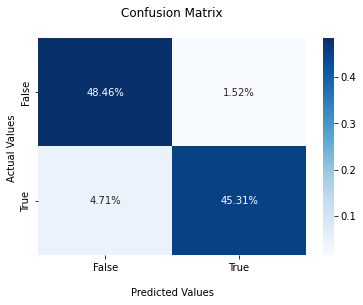

In [42]:
# Confusion Matrix
c_mat = metrics.confusion_matrix(y_test, y_pred)
ax = sb.heatmap(c_mat/np.sum(c_mat), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

## Applying K-Nearest Neighbors

In [22]:
# Testing K-Nearest Neighbhors Model
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(7, n_jobs = 2)
model_knn.fit(x_train, np.ravel(y_train))
y_pred_1 = model_knn.predict(x_test)

In [23]:
print(f'Accuracy = {metrics.accuracy_score(y_test, y_pred_1)}')

Accuracy = 0.994397275088411


In [24]:
print(f'F1 Score = {metrics.f1_score(y_test, y_pred_1)}')

F1 Score = 0.9944244735573589


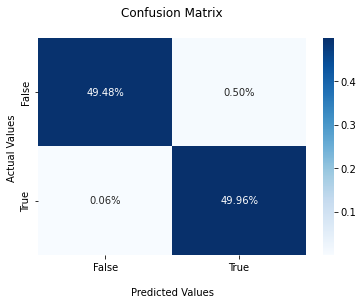

In [43]:
c_mat_1 = metrics.confusion_matrix(y_test, y_pred_1)
ax = sb.heatmap(c_mat_1/np.sum(c_mat_1), annot=True, fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

Comparing the two models' performances, it can be seen that the K-Nearest Neighbors Classifier does a significantly better job of detecting fraud compared to Logistic Regression.

## Task Reflection

###### 1. Describe your fraud detection model in elaboration.
As K-Nearest Neighbors performed better for this case, I will choose to explain this model in depth. KNN works such that each feature vector is located in a n-dimensional vector space, where n is the number of features. The classification for any given example is determined by finding the closest k "neighbors" (where k is defined as a hyperparameter) and their labels. In this case where there are only two classes, the label that is shared by the most number of neighbors out of the k neighbors is assigned to the new example. In other words, given a test case, if there are more neighbors that are not fraud than those that are, then the new test case will be deemed as not fraud.

As this is a lazy learning algorithm, a specific model isn't learned; rather, learning is only done when a test case needs to be labeled. The main complexity lies in determining the distance between vectors, which becomes more difficult as the number of features, and therefore dimensions, increases. This is not an issue here due to the somewhat low number of features. 

###### 2. How did you select variables to be included in the model?
Firstly, the name columns are not relevant in determining whether a transaction was fraud or not, because it's a high cardinality feature; in other words, once they are label encoded, there will not be much similarity between the different values in the name column, so it is not reliable in helping judge whether a transaction is fraud or not. 
Otherwise, I found it better to leave everything else to be included in the model because with a dataset that is this large, 11 features is a small enough quantity such that computations are not very long or tedious. Therefore, it doesn't hurt to include all of them. Their relative importance as determined by the LR model is explored in questions (4) and (5).

###### 3. Demonstrate the performance of the model by using best set of tools.
(Illustrated above through metrics such as accuracy, f1-score, and the confusion matrix)

###### 4. What are the key factors that predict fraudulent customer?

In [66]:
# Logistic Regression Coefficients

features = ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 
            'newbalanceDest', 'isFlaggedFraud', 'diffOldBalance', 'diffNewBalance']
feat_coefs = model_lr.coef_.tolist()
dict(zip(features, feat_coefs[0]))

{'step': 0.5848075877046106,
 'type': -0.06631924938995588,
 'amount': 62.38477163333927,
 'oldbalanceOrg': 15.856597932288393,
 'newbalanceOrig': -30.242310387124515,
 'oldbalanceDest': 21.330065971470844,
 'newbalanceDest': -24.617167127945468,
 'isFlaggedFraud': 21.403718984390128,
 'diffOldBalance': -22.84379801244616,
 'diffNewBalance': -10.876520810215833}

The above list shows the coefficients of each of the features in the logistic regression model. As we feature-scaled the data earlier, we can use these coefficients to determine their relative importance. It seems that the amount, balances, and the difference factors played the biggest role in determining whether a transaction is fraud or not, whereas the steps and type of payment did not play as much of a role.

###### 5. Do these factors make sense? If yes, How? If not, How not?
These factors do mostly make sense. It is obvious that the steps would not play much of a role due to the lack of correlation between time and validity of transactions. The payment amounts and balances played a big role, which is expected because of the common behavior of fraud transactions stated in the data dictionary, where frauds would often empty customers' accounts and then cash out all the money (atleast in this specific dataset), so this is a pattern that the model may have caught onto, causing these factors to largely impact the classification. 
The one disparity lies in the fact that the type of payment barely affected the classification, since all fraud transactions in this dataset were either transfers or cash_outs, which the model may or may not have identified.

###### 6. What kind of prevention should be adopted while company update its infrastructure?
While the infrastructure is being updated, public records of applicants should be scrutinized to determine their credit worthiness and reliability (like employee information and credit history). In addition, referring to past data (such as cases from this dataset) can be insightful in determining factors that help identify whether a transaction is fraud or not.

###### 7. Assuming these actions have been implemented, how would you determine if they work?
There would have to be a testing phase for the model (perhaps over a period of several months) to check whether the model is flagging cases appropriately or not. In order for the model to be accurate, the ratio of flagged transactions to actual fraud transactions must be nearing 1. If this happens to be the case, it can stay over the long-term as it can be of great help in preventing fraud transactions from completing.